### The goal of this notebook is to identify which Bedmap1 points are covered by other datasets

In [1]:
%matplotlib inline
import matplotlib 
import matplotlib.pyplot as plt

import importlib
import numpy as np
import os
import pathlib
import shapefile as shp  # Requires the pyshp package; I ran `pip install pyshp`


In [7]:
import detangle_bedmap_utils
importlib.reload(detangle_bedmap_utils)
from detangle_bedmap_utils import (expand_range, find_closest_bedmap,
                                   load_bedmap_ll, load_bedmap_xy, 
                                   subsample_tracks_uniform, 
                                  )

In [3]:
gl_filepath = "/Users/lindzey/Data/Quantarctica3/Glaciology/ASAID/ASAID_GroundingLine_Simplified.shp"

# If I do it this way, I can plot as points (but not lines!). This is easier than having to iterate through each segment.
sf = shp.Reader(gl_filepath)
gl_xx = []
gl_yy = []
for shape in sf.shapeRecords():
    x = [i[0] for i in shape.shape.points[:]]
    y = [i[1] for i in shape.shape.points[:]]
    gl_xx.extend(x)
    gl_yy.extend(y)

In [4]:
bm1_path = "/Users/lindzey/RadarData/ANTARCTIC/BEDMAP/BEDMAP1/BEDMAP1_1966-2000_AIR_BM1.csv"
bm1_lon, bm1_lat = load_bedmap_ll(bm1_path)
bm1_xx, bm1_yy = load_bedmap_xy(bm1_path)

## UTIG

* The IRE survey made it into BEDMAP1 (And shows up attributed to UTIG in BEDMAP2)

1991_CASERTZ is the equivalent survey in the BEDMAP2 dataset.

However, it ALSO shows up in the 1999 SOAR grouping with other WAIS surveys, but with slightly different positioning data for each point. (The BEDMAP1 points appear to exactly match 1991_CASERTZ).


In [5]:
ire_path = "/Users/lindzey/RadarData/ANTARCTIC/BEDMAP/BEDMAP2/UTIG_1991_CASERTZ_AIR_BM2.csv"
ire_lon, ire_lat = load_bedmap_ll(ire_path)
ire_xx, ire_yy = load_bedmap_xy(ire_path)

In [9]:
# 100m spacing doesn't do much for UTIG's dataset.
subsampling = 1000
min_bm1_idxs = find_closest_bedmap(ire_xx, ire_yy, bm1_xx, bm1_yy, subsampling=subsampling)

Subsampled 32812 -> 18442


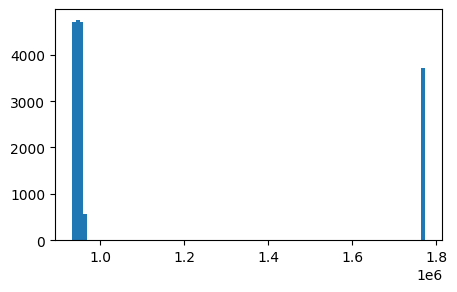

In [10]:
# Let's check the distribution of these closest points
fig = plt.figure(figsize=(5,3))
ax = fig.subplots(1,1)
ax.hist(min_bm1_idxs, bins=100);

The above histogram showed that there are two separate populations 
of points in BEDMAP1 corresponding to this survey. Assuming that the
points are contiguous, this corresponds to two range bins.


In [11]:
group1_idxs, = np.where(np.array(min_bm1_idxs) < 1000000)
group1_idxs = np.array(min_bm1_idxs)[group1_idxs]

group2_idxs, = np.where(np.array(min_bm1_idxs) > 1000000)
group2_idxs = np.array(min_bm1_idxs)[group2_idxs]

group1_range = np.arange(np.min(group1_idxs), np.max(group1_idxs))
group2_range = np.arange(np.min(group2_idxs), np.max(group2_idxs))

In [12]:
len(ire_xx), len(group1_range) + len(group2_range)

(32812, 32809)

If we assume a one-to-one mapping of points from the BEDMAP2 dataset to BEDMAP1, we're missing a handful of points. Let's try searching outward from both sides of the groups until points are out-of-range.

In [13]:
# Try extending the bedmap range at the boundaries to catch all points
group1_start, group1_end = expand_range(group1_idxs, ire_xx, ire_yy, bm1_xx, bm1_yy, 10000)
group2_start, group2_end = expand_range(group2_idxs, ire_xx, ire_yy, bm1_xx, bm1_yy, 10000)
group1_range = np.arange(group1_start, group1_end+1)  # group1_end is inclusive
group2_range = np.arange(group2_start, group2_end+1) 

For BM1 idx 934077, min_dist = 1837.87 km
For BM1 idx 960289, min_dist = 2915.07 km
For BM1 idx 1766286, min_dist = 1837.76 km
For BM1 idx 1772889, min_dist = 2880.58 km


In [14]:
# Assuming the datapoints in BEDMAP2 are one-to-one with those in BEDMAP1, check if we got 'em all:
len(ire_xx), len(group1_range) + len(group2_range)

(32812, 32813)

OK, we're within one datapoint, call that good enough.


Text(0.5, 1.0, 'BEDMAP1: 1766287 - 1772888')

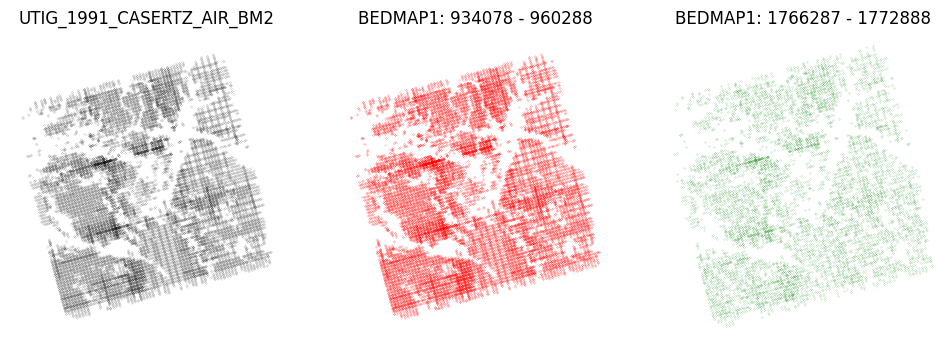

In [16]:
# Confirm that our continguous ranges of points are likely to correspond to this survey
fig = plt.figure(figsize=(12,4))
ax1, ax2, ax3, = fig.subplots(1,3)
#ax.plot(gl_xx, gl_yy, '.', color='grey', markersize=0.5)
for ax in [ax1, ax2, ax3]:
    ax.axis('equal') 
    ax.axis('off')
    #ax.plot(bm1_xx[group1_idxs], bm1_yy[group1_idxs], 'r.')
    #ax.plot(bm1_xx[group2_idxs], bm1_yy[group2_idxs], 'g.')
ax1.plot(ire_xx, ire_yy, 'k.', markersize = 0.1)
ax1.set_title(pathlib.Path(ire_path).stem)
ax2.plot(bm1_xx[group1_range], bm1_yy[group1_range], 'r.', markersize=0.2)
ax2.set_title("BEDMAP1: {} - {}".format(group1_range[0], group1_range[-1]))
ax3.plot(bm1_xx[group2_range], bm1_yy[group2_range], 'g.', markersize=0.2)
ax3.set_title("BEDMAP1: {} - {}".format(group2_range[0], group2_range[-1]))

Text(0.5, 1.0, 'BEDMAP1: 1766287 - 1772888')

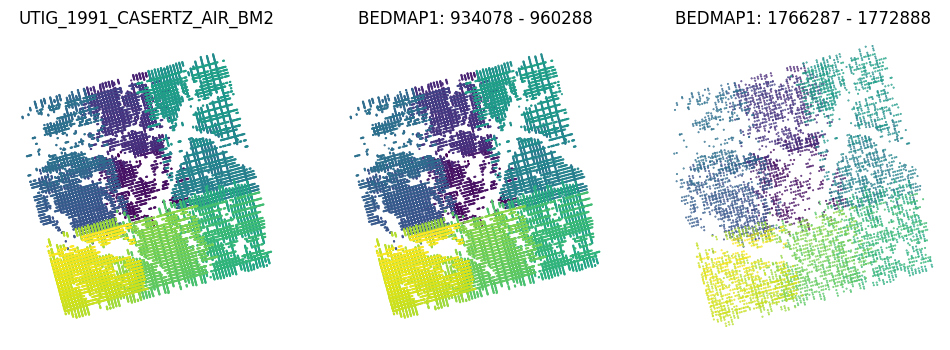

In [ ]:
# Let's confirm that the points are organized in some sort of order
# It looks like there are two groupings of points in BEDMAP1 that correspond to the IRE dataset.
# Both of them are contiguous.
fig = plt.figure(figsize=(12,4))
ax1, ax2, ax3, = fig.subplots(1,3)
#ax.plot(gl_xx, gl_yy, '.', color='grey', markersize=0.5)
for ax in [ax1, ax2, ax3]:
    ax.axis('equal') 
    ax.axis('off')
ax1.scatter(ire_xx, ire_yy, c=np.arange(0,len(ire_xx)), edgecolors=None, s=0.3)
ax1.set_title(pathlib.Path(ire_path).stem)
ax2.scatter(bm1_xx[group1_range], bm1_yy[group1_range], c=np.arange(0, len(group1_range)), edgecolors=None, s=0.3)
ax2.set_title("BEDMAP1: {} - {}".format(group1_range[0], group1_range[-1]))
ax3.scatter(bm1_xx[group2_range], bm1_yy[group2_range], c=np.arange(0, len(group2_range)), edgecolors=None, s=0.2)
ax3.set_title("BEDMAP1: {} - {}".format(group2_range[0], group2_range[-1]))

In [ ]:
print("The {} survey includes {}-{} and {}-{}".format(pathlib.Path(ire_path).stem, group1_start, group1_end, group2_start, group2_end))

The UTIG_1991_CASERTZ_AIR_BM2 survey includes 934078-960288 and 1766287-1772888


The above ranges have been manually copied into extract_bedmap_tracks as indices to omit in the BEDMAP1 layer.